# LDA2Vec
Adapted from tensorflow implementation: 

(Current) https://github.com/nateraw/Lda2vec-Tensorflow

(Old) https://github.com/meereeum/lda2vec-tf

(Original) https://github.com/cemoody/lda2vec

In [1]:
import pandas as pd
import numpy as np
import pyLDAvis
import pickle
import random

In [2]:
import sys
sys.path.append('./Lda2vec-Tensorflow-master')

In [3]:
from lda2vec import *

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0Metal device set to: Apple M1



## Find Ending Index of Documents for Each Year

In [5]:
data = pd.read_csv("papers.csv")

In [6]:
data = data[data["paper_text"].notnull()]

In [7]:
data = data.sort_values(by=["year"], kind='mergesort')

In [8]:
years = list(data["year"].unique())
counts = list(data["year"].value_counts())[::-1]
for i in range(1,len(counts)):
  counts[i] += counts[i-1]
year_index = {years[i]:counts[i] for i in range(len(years))}

In [9]:
year_index

{1987: 90,
 1988: 184,
 1989: 285,
 1990: 412,
 1991: 552,
 1992: 695,
 1993: 839,
 1994: 989,
 1995: 1139,
 1996: 1290,
 1997: 1442,
 1998: 1594,
 1999: 1746,
 2000: 1904,
 2001: 2101,
 2002: 2299,
 2003: 2503,
 2004: 2710,
 2005: 2917,
 2006: 3124,
 2007: 3341,
 2008: 3591,
 2009: 3853,
 2010: 4145,
 2011: 4451,
 2012: 4811,
 2013: 5179,
 2014: 5582,
 2015: 5993,
 2016: 6562,
 2017: 7241}

## Preprocessing

$\tt cleaned.txt$ is a txt file with all NIPS papers with all stop words and words with $\rm{length} \leq 3$ removed.

Preprocess incorporates tokenization (splitting sentences into words), creating a vocabulary to save mappings from tokens to integer indices, and generating skip-grams.

In [5]:
df = pd.read_csv("cleaned.txt")

In [6]:
df = df[3341:] # Use only 2008-2017 papers

In [7]:
papers = random.sample(list(range(3341,7241)), 300)
papers.sort()

In [8]:
select = df.loc[papers, "stop_removed_paper_text"]

In [9]:
groupList = []
for i in range(300):
    temp = pd.DataFrame()
    temp['stop_removed_paper_text'] = [select.iloc[i]]
    groupList.append(temp)

In [10]:
aggregate = pd.concat(groupList, ignore_index=True)

In [11]:
aggregate

,stop_removed_paper_text
0,efficient exact inference planar ising models ...
1,characteristic kernels groups semigroups kenji...
2,near optimal regret bounds reinforcement learn...
3,near minimax recursive density estimation bina...
4,homotopy algorithm lasso online observations p...
...,...
295,meta learning perspective cold start recommend...
296,sticking landing simple lower variance gradien...
297,kernel feature selection conditional covarianc...
298,active learning peers keerthiram murugesan jai...


In [12]:
# Initialize a preprocessor
P = nlppipe.Preprocessor(aggregate, "stop_removed_paper_text", max_features=30000, maxlen=10000, min_count=30)

/Users/keanl/miniforge3/lib/python3.9/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [13]:
# Run the preprocessing on your dataframe
P.preprocess()


---------- Tokenizing Texts ----------


300it [01:54,  2.63it/s]


Removing 23114 low frequency tokens out of 26374 total tokens

---------- Getting Skipgrams ----------


300it [00:06, 46.19it/s]


In [14]:
# Should we load pretrained embeddings from file
load_embeds = True

# Load embeddings from file if we choose to do so
if load_embeds:
    # Load embedding matrix from file path - change path to where you saved them
    embedding_matrix = P.load_glove("glove.6B.300d.txt")
else:
    embedding_matrix = None

/Users/keanl/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
# Save data to data_dir
P.save_data("doc_collect2", embedding_matrix=embedding_matrix)

## Using the LDA2Vec Model

Using the LDA2Vec model on preprocessed data.

In [16]:
# Path to preprocessed data
data_path  = "doc_collect"
# Whether or not to load saved embeddings file
load_embeds = True

# Load data from files
(idx_to_word, word_to_idx, freqs, pivot_ids,
 target_ids, doc_ids, embed_matrix) = utils.load_preprocessed_data(data_path, load_embed_matrix=load_embeds)

In [17]:
# Number of unique documents
num_docs = doc_ids.max() + 1
# Number of unique words in vocabulary (int)
vocab_size = len(freqs)
# Embed layer dimension size
# If not loading embeds, change 128 to whatever size you want.
embed_size = embed_matrix.shape[1] if load_embeds else 128
# Number of topics to cluster into
num_topics = 40
# Amount of iterations over entire dataset
num_epochs = 40
# Batch size - Increase/decrease depending on memory usage
batch_size = 4096
# Epoch that we want to "switch on" loss_lda
switch_loss_epoch = 0
# Pretrained embeddings value
pretrained_embeddings = embed_matrix if load_embeds else None
# If True, save logdir, otherwise don't
save_graph = False

In [18]:
# Initialize the model
m = model(num_docs,
          vocab_size,
          num_topics,
          embedding_size=embed_size,
          pretrained_embeddings=pretrained_embeddings,
          freqs=freqs,
          batch_size = batch_size,
          save_graph_def=save_graph)


EPOCH: 1
LOSS 13.081886 w2v 5.0769815 lda 6.7172074 reg 1.2876498

EPOCH: 2
LOSS 11.474617 w2v 4.7606964 lda 5.582585 reg 1.1311623

EPOCH: 3
LOSS 10.554083 w2v 4.7307167 lda 5.086642 reg 0.7363758

EPOCH: 4
LOSS 9.932104 w2v 4.712239 lda 4.910267 reg 0.3094887

EPOCH: 5
LOSS 9.716719 w2v 4.739106 lda 4.8606863 reg 0.11688019
Instructions for updating:
keep_dims is deprecated, use keepdims instead
---------Closest 10 words to given indexes----------
Topic 0 : etc, subsequently, optimizes, discriminatively, picks, consequently, correspondence, segmentation, penalized, corr
Topic 1 : conditions, penalized, notably, good, close, especially, cient, conditioned, absence, mild
Topic 2 : pexplore, episodes, relevance, editors, lifted, regret, conference, notice, follow, continue
Topic 3 : shallow, <UNK>, ridge, theorem, kronecker, bregman, ingredients, leaf, wgan, pedestrian
Topic 4 : firing, adapted, feature, rmse, detectors, caltech, learned, recorded, shared, outperform
Topic 5 : progress

LOSS 9.464103 w2v 4.57942 lda 4.880853 reg 0.003851654

EPOCH: 12
LOSS 9.200389 w2v 4.308984 lda 4.8885055 reg 0.0029038808

EPOCH: 13
LOSS 8.974926 w2v 4.078182 lda 4.8947954 reg 0.0019461726

EPOCH: 14
LOSS 9.404758 w2v 4.5021653 lda 4.900967 reg 0.0016284348

EPOCH: 15
LOSS 9.126157 w2v 4.2192955 lda 4.90561 reg 0.001253074
---------Closest 10 words to given indexes----------
Topic 0 : andrew, optimizes, kingma, propagation, backpropagation, subsequently, adam, membership, iclr, hyperparameters
Topic 1 : certain, consistent, conditions, mild, cient, asymptotically, functionals, szepesv, early, notably
Topic 2 : pexplore, thalnet, episodes, lifted, speaking, delays, child, reading, gold, episode
Topic 3 : <UNK>, axioms, glasso, kronecker, subtree, gold, played, hours, matlab, reweighted
Topic 4 : sssm, nonstationary, firing, plotted, collected, tica, discriminatively, arccos, approximated, labels
Topic 5 : progression, reversible, matter, transmission, splitting, fascicles, speedup, 

LOSS 8.799606 w2v 3.8812964 lda 4.9178066 reg 0.0005029714

EPOCH: 22
LOSS 8.866281 w2v 3.9476247 lda 4.9181724 reg 0.000485717

EPOCH: 23
LOSS 9.118594 w2v 4.200172 lda 4.9180307 reg 0.00039211215

EPOCH: 24
LOSS 9.001373 w2v 4.0824747 lda 4.9184513 reg 0.00044742844

EPOCH: 25
LOSS 8.791039 w2v 3.872612 lda 4.9180727 reg 0.0003555585
---------Closest 10 words to given indexes----------
Topic 0 : kingma, kakade, iclr, andrew, abbeel, lstd, daniel, propagation, koller, optimizes
Topic 1 : szepesv, notably, gmms, olkopf, certain, cient, merely, conditions, consistent, regime
Topic 2 : delays, update, speaking, collaborative, pexplore, alternatives, feedback, explicit, scoring, child
Topic 3 : <UNK>, glasso, gold, axioms, acceptance, played, kronecker, animal, feasibility, recipe
Topic 4 : attentivechrome, sssm, discriminatively, exploits, adjusted, summarizes, obtaining, nonstationary, labels, organization
Topic 5 : reversible, splitting, fascicles, progression, multipliers, matter, ign

LOSS 8.611194 w2v 3.6951025 lda 4.9157896 reg 0.000302752

EPOCH: 32
LOSS 8.606767 w2v 3.691088 lda 4.9154315 reg 0.0002475811

EPOCH: 33
LOSS 8.70696 w2v 3.791994 lda 4.914659 reg 0.0003074049

EPOCH: 34
LOSS 8.671676 w2v 3.7567854 lda 4.914597 reg 0.00029197035

EPOCH: 35
LOSS 8.85953 w2v 3.9456217 lda 4.913618 reg 0.0002892375
---------Closest 10 words to given indexes----------
Topic 0 : kakade, koller, iclr, kingma, parameters, daniel, abbeel, lstd, bayesian, efficient
Topic 1 : szepesv, notably, gmms, olkopf, merely, seller, finds, regime, cient, needs
Topic 2 : delays, update, speaking, diff, pexplore, alternatives, smith, explicit, dead, workers
Topic 3 : <UNK>, participant, acceptance, feasibility, projects, gold, axioms, animal, glasso, fish
Topic 4 : attentivechrome, adjusted, summarizes, eigennet, sssm, organization, obtaining, discriminatively, bars, lowest
Topic 5 : ignore, splitting, reversible, matter, fascicles, progression, slope, cand, multipliers, hundreds
Topic 6 :

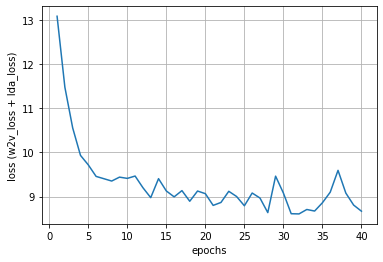

In [19]:
# Train the model
m.train(pivot_ids,
        target_ids,
        doc_ids,
        len(pivot_ids),
        num_epochs,
        idx_to_word=idx_to_word,
        switch_loss_epoch=switch_loss_epoch)

## Get Word and Topic Embeddings

Visualize topics

In [20]:
idx_to_word

{1: 'learning',
 2: 'model',
 3: 'algorithm',
 4: 'data',
 5: 'function',
 6: 'time',
 7: 'problem',
 8: 'number',
 9: 'matrix',
 10: 'distribution',
 11: 'given',
 12: 'models',
 13: 'figure',
 14: 'results',
 15: 'information',
 16: 'methods',
 17: 'method',
 18: 'based',
 19: 'linear',
 20: 'training',
 21: 'neural',
 22: 'optimization',
 23: 'section',
 24: 'algorithms',
 25: 'case',
 26: 'approach',
 27: 'different',
 28: 'state',
 29: 'performance',
 30: 'random',
 31: 'probability',
 32: 'following',
 33: 'functions',
 34: 'value',
 35: 'theorem',
 36: 'optimal',
 37: 'large',
 38: 'network',
 39: 'work',
 40: 'gradient',
 41: 'parameters',
 42: 'analysis',
 43: 'bound',
 44: 'kernel',
 45: 'error',
 46: 'sample',
 47: 'space',
 48: 'features',
 49: 'pages',
 50: 'machine',
 51: 'networks',
 52: 'samples',
 53: 'gaussian',
 54: 'loss',
 55: 'vector',
 56: 'convex',
 57: 'process',
 58: 'order',
 59: 'example',
 60: 'image',
 61: 'size',
 62: 'feature',
 63: 'proposed',
 64: 'mea

In [21]:
doc_embed = m.sesh.run(m.mixture.doc_embedding)

In [22]:
topic_embed = m.sesh.run(m.mixture.topic_embedding)

In [23]:
word_embed = m.sesh.run(m.w_embed.embedding)

In [24]:
# Extract all unique words in order of index 0-vocab_size
vocabulary = []
for k,v in idx_to_word.items():
    vocabulary.append(v)

In [25]:
doc_lengths = np.load("doc_collect2/doc_lengths.npy")

In [26]:
vis_data = utils.prepare_topics(doc_embed, topic_embed, word_embed, np.array(vocabulary), doc_lengths=doc_lengths,
                              term_frequency=freqs, normalize=True)

In [27]:
prepared_vis_data = pyLDAvis.prepare(**vis_data)

/Users/keanl/miniforge3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/keanl/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/keanl/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/keanl/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/keanl/miniforge3/lib/python3.9/site-packages/pa

In [28]:
pyLDAvis.display(prepared_vis_data)

In [29]:
norm_topic = topic_embed / np.reshape(np.linalg.norm(topic_embed, axis=1), (topic_embed.shape[0], 1))
norm_word = word_embed / np.reshape(np.linalg.norm(word_embed, axis=1), (word_embed.shape[0], 1))
cosine = np.dot(norm_topic, norm_word.T)

In [30]:
sim_idx = np.argsort(cosine, kind='stable')

In [31]:
idxs = np.zeros((sim_idx.shape[0],10))
for i in range(sim_idx.shape[0]):
    idxs[i] = sim_idx[i][-10:]

In [32]:
coherence = 0
count = 0
for i in range(idxs.shape[0]):
    for j in range(idxs.shape[1]-1):
        for k in range(j+1, idxs.shape[1]):
            count += 1
            coherence += np.dot(norm_word[int(idxs[i][j])], norm_word[int(idxs[i][k])].T)
print(f"Overall Coherence: {coherence/count}")

Overall Coherence: 0.3727911552096096


In [33]:
np.save("doc_embed_col2.npy", doc_embed)

In [34]:
np.save("word_embed_col2.npy", word_embed)

In [35]:
np.save("topic_embed_col2.npy", topic_embed)